# Tiny Imgenet

Creating an image classifier on tiny-imgnet dataset using tinyai

# Setup

In [1]:
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *
from tinyai.training import *
from fastprogress import progress_bar

In [2]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [3]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

In [4]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')

In [5]:
bs = 512

grabbing ale images from one category

In [6]:
glob(str(path/'train/n01443537/images/*.JPEG'))[:10]

['data/tiny-imagenet-200/train/n01443537/images/n01443537_170.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_209.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_295.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_257.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_389.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_342.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_358.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_255.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_48.JPEG',
 'data/tiny-imagenet-200/train/n01443537/images/n01443537_92.JPEG']

In [7]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True) # here we take all images not just one category
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return self.files[i],Path(self.files[i]).parent.parent.name

In [8]:
tds = TinyDS(path/'train')

In [9]:
tds[0]

('data/tiny-imagenet-200/train/n02906734/images/n02906734_403.JPEG',
 'n02906734')

for validation we need to read `val_annotations.txt` sincce files in validation directory are not sorted

In [10]:
path_anno = path/'val'/'val_annotations.txt'
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [11]:
print(path_anno.read_text()[:251])

val_0.JPEG	n03444034	0	32	44	62
val_1.JPEG	n04067472	52	55	57	59
val_2.JPEG	n04070727	4	0	60	55
val_3.JPEG	n02808440	3	3	63	63
val_4.JPEG	n02808440	9	27	63	48
val_5.JPEG	n04399382	7	0	59	63
val_6.JPEG	n04179913	0	0	63	56
val_7.JPEG	n02823428	5	0	57	63


In [12]:
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i],anno[os.path.basename(self.files[i])]

In [13]:
vds = TinyValDS(path/'val')

In [14]:
vds[0]

('data/tiny-imagenet-200/val/images/val_1755.JPEG', 'n03670208')

In [15]:
len(tds)

100000

In [16]:
id2str = (path/'wnids.txt').read_text().splitlines()
str2id = {v:k for k,v in enumerate(id2str)}

In [17]:
id2str[:5],str2id['n01443537']

(['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582'], 22)

Normalize the data

In [18]:
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [19]:
def tfmx(x):
    img = read_image(x, mode=ImageReadMode.RGB)/255
    return (img-xmean[:,None,None])/xstd[:,None,None]

In [20]:
def tfmy(y): return tensor(str2id[y])

In [21]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [22]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [23]:
xi,yi = tfm_tds[0]
xi,yi,id2str[yi]

(tensor([[[ 0.32219,  0.32219,  0.34937,  ..., -0.11266, -0.15343, -0.18061],
          [ 0.19989,  0.21348,  0.28142,  ..., -0.09908, -0.13984, -0.16702],
          [ 0.51244,  0.52603,  0.49885,  ..., -0.08549, -0.12625, -0.15343],
          ...,
          [ 0.66192,  0.59397,  0.51244,  ..., -0.95519, -0.77853, -0.90084],
          [ 0.60756,  0.52603,  0.44449,  ..., -0.79212, -0.57470, -0.61546],
          [ 0.53962,  0.47167,  0.34937,  ..., -0.73777, -0.66982, -0.79212]],
 
         [[-0.62310, -0.60703, -0.55882,  ..., -1.02487, -1.07308, -1.10522],
          [-0.83202, -0.78381, -0.65524,  ..., -1.00880, -1.05701, -1.08915],
          [-0.54275, -0.49454, -0.44633,  ..., -0.99273, -1.04094, -1.07308],
          ...,
          [ 0.43756,  0.35721,  0.30900,  ..., -1.47485, -1.29807, -1.44271],
          [ 0.22864,  0.13222,  0.03580,  ..., -1.37843, -1.15344, -1.20165],
          [ 0.06794, -0.01242, -0.15705,  ..., -1.33021, -1.33021, -1.47485]],
 
         [[-0.64044, -0.6257

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

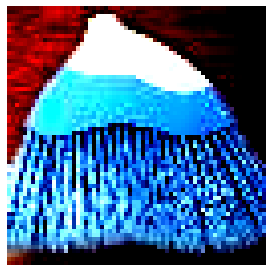

In [24]:
show_image(xi)

We need to denormalize the image

In [25]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

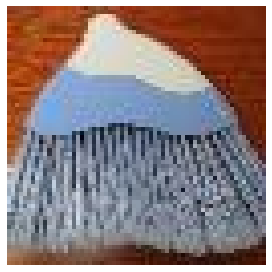

In [26]:
show_image(denorm(xi));

In [27]:
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=8)

In [28]:
xb,yb = b = next(iter(dltrn))

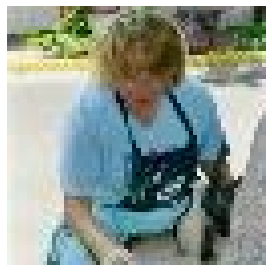

In [29]:
show_image(denorm(xb[0]));

In [30]:
(path/'words.txt').read_text().splitlines()[:30]

['n00001740\tentity',
 'n00001930\tphysical entity',
 'n00002137\tabstraction, abstract entity',
 'n00002452\tthing',
 'n00002684\tobject, physical object',
 'n00003553\twhole, unit',
 'n00003993\tcongener',
 'n00004258\tliving thing, animate thing',
 'n00004475\torganism, being',
 'n00005787\tbenthos',
 'n00005930\tdwarf',
 'n00006024\theterotroph',
 'n00006150\tparent',
 'n00006269\tlife',
 'n00006400\tbiont',
 'n00006484\tcell',
 'n00007347\tcausal agent, cause, causal agency',
 'n00007846\tperson, individual, someone, somebody, mortal, soul',
 'n00015388\tanimal, animate being, beast, brute, creature, fauna',
 'n00017222\tplant, flora, plant life',
 'n00019046\tnative',
 'n00019128\tnatural object',
 'n00019613\tsubstance',
 'n00020090\tsubstance',
 'n00020827\tmatter',
 'n00021265\tfood, nutrient',
 'n00021734\tnutrient',
 'n00021939\tartifact, artefact',
 'n00022903\tarticle',
 'n00023100\tpsychological feature']

In [31]:
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

In [32]:
titles = [synsets[id2str[o]] for o in yb]
print(', \n'.join(titles[:20]))

potter's wheel, 
kimono, 
meat loaf, 
water tower, 
Chihuahua, 
limousine, 
dining table, 
rugby ball, 
sombrero, 
brown bear, 
military uniform, 
rugby ball, 
black widow, 
flagpole, 
mushroom, 
dragonfly, 
kimono, 
Yorkshire terrier, 
remote control, 
hog


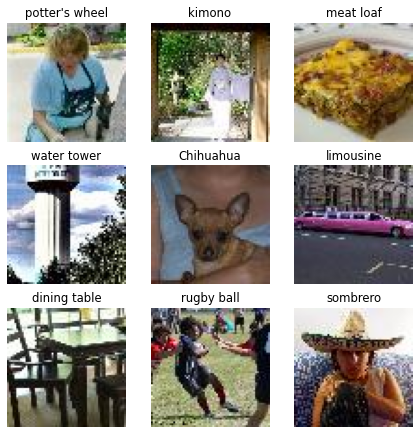

In [33]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [34]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

## Basic model

In [35]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

adding data augmentation

In [36]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [37]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [38]:
nfs = (32,64,128,256,512,1024)

In [39]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
#     layers += [ResBlock(nfs[0], nfs[0], ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

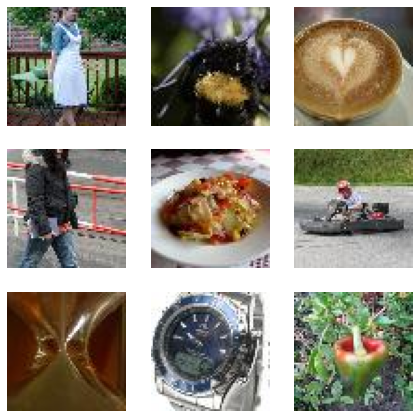

In [41]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [42]:
learn.summary()

Tot params: 19775824; MFLOPS: 303.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(512, 3, 64, 64)|(512, 32, 64, 64)|2432|9.8|
|ResBlock|(512, 32, 64, 64)|(512, 64, 32, 32)|57792|58.7|
|ResBlock|(512, 64, 32, 32)|(512, 128, 16, 16)|230272|58.7|
|ResBlock|(512, 128, 16, 16)|(512, 256, 8, 8)|919296|58.7|
|ResBlock|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|ResBlock|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


In [43]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [44]:
lr_cbs = [DeviceCB(), augcb, MixedPrecision(), ProgressCB()]

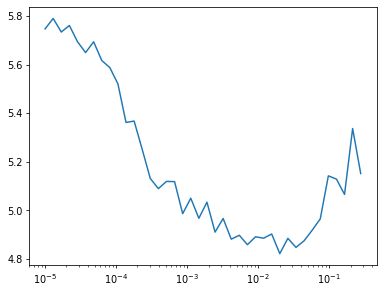

In [44]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [45]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

In [46]:
epochs = 25
lr = 0.01
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.111,4.404,0,train
0.180,3.854,0,eval
0.223,3.645,1,train
0.245,3.416,1,eval
0.277,3.285,2,train
0.296,3.113,2,eval
0.311,3.052,3,train
0.290,3.203,3,eval
0.346,2.836,4,train
0.326,2.983,4,eval


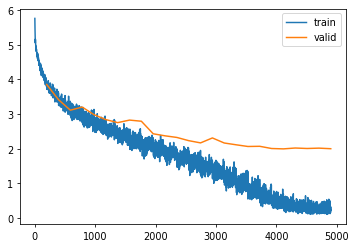

In [47]:
learn.fit(epochs)

In [50]:
torch.save(learn.model, 'nbs/models/inettiny-basic-25')

## Deeper

In [46]:
def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

In [47]:
nbks = (3,2,2,1,1)

We just replaced ResBlock with res_blocks 

In [48]:
def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

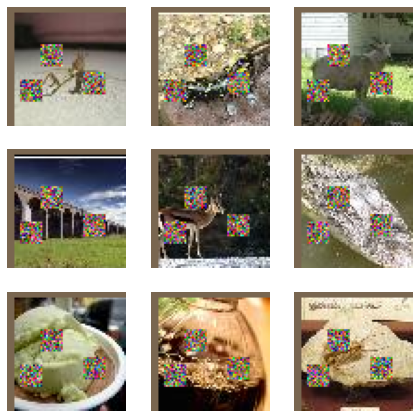

In [54]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [55]:
learn.summary()

Tot params: 21426800; MFLOPS: 710.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 3, 64, 64)|(512, 32, 64, 64)|28320|115.1|
|Sequential|(512, 32, 64, 64)|(512, 64, 32, 32)|206016|209.7|
|Sequential|(512, 64, 32, 32)|(512, 128, 16, 16)|525952|134.2|
|Sequential|(512, 128, 16, 16)|(512, 256, 8, 8)|2100480|134.2|
|Sequential|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|Sequential|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


note that our MFLOPS doubled.

In [49]:
opt_func = partial(optim.AdamW, eps=1e-5)

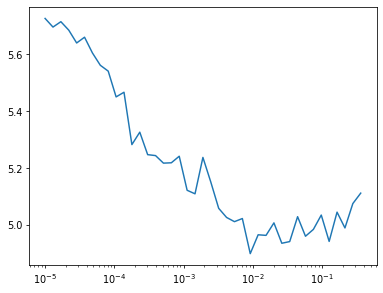

In [57]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

epochs = 25
lr = 3e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.084,4.553,0,train
0.128,4.120,0,eval
0.203,3.697,1,train
0.228,3.482,1,eval
0.267,3.257,2,train
0.268,3.298,2,eval
0.315,2.976,3,train
0.297,3.139,3,eval
0.351,2.771,4,train
0.278,3.477,4,eval


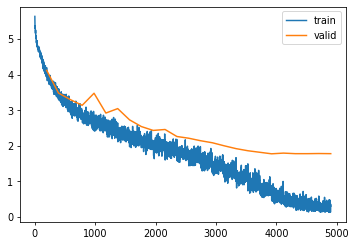

In [59]:
learn.fit(epochs)

In [60]:
torch.save(learn.model, 'nbs/models/inettiny-custom-25')

## More augmentation
TrivialAugmnetWide augmnetation - https://arxiv.org/abs/2103.10158

In [50]:
aug_tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     T.TrivialAugmentWide())

norm_tfm = T.Normalize(xmean, xstd)
erase_tfm = RandErase()

The problem with adding more augmentation is that if we get a really augmented batch, it could mess up our gradients.\
We need to implement augmentation on per item level instead of per batch level.

In [51]:
# Some of the transforms require the PIL Image format.
from PIL import Image

In [52]:
def tfmx(x, aug=False):
    x = Image.open(x).convert('RGB')
    if aug: x = aug_tfms(x)
    x = TF.to_tensor(x)
    x = norm_tfm(x)
    if aug: x = erase_tfm(x[None])[0]
    return x

In [53]:
tfm_tds = TfmDS(tds, partial(tfmx, aug=True), tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [54]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

We will als modifiy our model once again,\
We will create a `true` identity (before we did relu after addition) path just like in - https://arxiv.org/abs/1603.05027

In [55]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1     , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

In [56]:
def get_model(): return get_dropmodel(nbks=(4,3,3,2,1), drop=0.1)

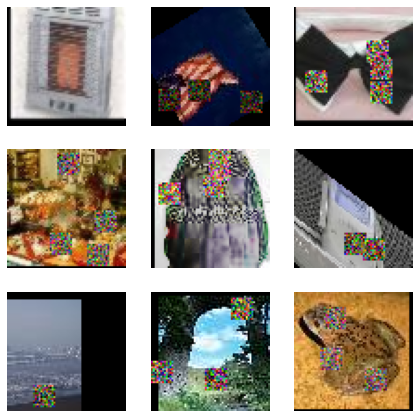

In [57]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

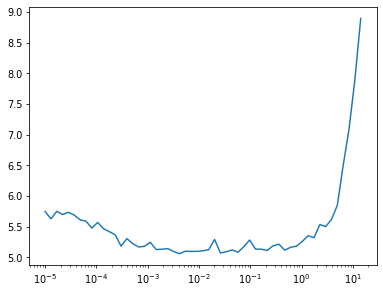

In [58]:
learn = Learner(get_model(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

The lr finder finally looks smooth

In [61]:
epochs = 50
lr = 0.1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.022,5.091,0,train
0.032,4.900,0,eval
0.045,4.785,1,train
0.057,4.635,1,eval
0.077,4.499,2,train
0.089,4.353,2,eval
0.111,4.211,3,train
0.150,3.878,3,eval
0.149,3.931,4,train
0.143,4.122,4,eval


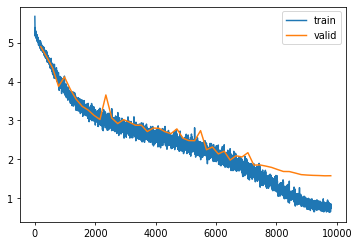

In [62]:
learn.fit(epochs)

In [66]:
torch.save(learn.model, 'models/inettiny-trivaug-50')

### fin -